# Coursework 2 
### Perform k-nearest neighbour (KNN) retrieval experiments according to standard practices in pattern recognition. Use retrieval error (ie @rank1, @rank10) as the performance metric to evaluate different methods. Your baseline approach is KNN on provided features. Use distance metric learning methods to improve a baseline performance.

#### So, firstly, we need to create a baseline, which is KNN on provided features. 

In [9]:
from scipy.io import loadmat
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()

## Load features

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open("PR_data/feature_data.json", "r") as file:
    features = json.load(file)
    
data_features = np.asarray(features)

print('Data shape: {}'.format(data_features.shape))

Data shape: (14096, 2048)


## Load data

In [11]:
#Load labels
labelss = loadmat('cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()

#Load camId
cam_Ids = loadmat('cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()

#Load indexes
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()
query_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()
gallery_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()

#Load training indexes
print("training indexes : {}".format(train_idxs.shape))
print("query indexes : {}".format( query_idxs.shape))
print("gallery indexes : {}".format( gallery_idxs.shape))

training indexes : (7368,)
query indexes : (1400,)
gallery indexes : (5328,)


In [12]:
#converting to python index notation

train_idxs = train_idxs - 1
query_idxs = query_idxs - 1
gallery_idxs = gallery_idxs - 1

## Separate the features and data into training, query and gallery sets 

In [13]:
train_f = []
train_label = []
train_camid = []
# divide the features data into training 
for i in range (len(train_idxs)):
    train_f.append(data_features[train_idxs[i]])
    train_camid.append(cam_Ids[train_idxs[i]])
    train_label.append(labelss[train_idxs[i]])
    
train_f = np.asarray(train_f)    
train_label = np.asarray(train_label)
train_camid = np.asarray(train_camid)

In [14]:
#features, cam, label data into gallery
query_f = []
query_camid = []
query_label = []

for i in range (len(query_idxs)):
    query_f.append(data_features[query_idxs[i]])
    query_camid.append(cam_Ids[query_idxs[i]])
    query_label.append(labelss[query_idxs[i]])
    
query_f = np.asarray(query_f) 
query_label = np.asarray(query_label)
query_camid = np.asarray(query_camid)

In [15]:
#features, cam, label data into gallery
gallery_f = []
gallery_camid = []
gallery_label = []

for i in range (len(gallery_idxs)):
    gallery_f.append(data_features[gallery_idxs[i]])
    gallery_camid.append(cam_Ids[gallery_idxs[i]])
    gallery_label.append(labelss[gallery_idxs[i]])
       
gallery_f = np.asarray(gallery_f)  
gallery_camid = np.asarray(gallery_camid)  
gallery_label = np.asarray(gallery_label)  

### Concatenate query and gallery features/labels/cam ids

In [16]:
#stacking labels, cam ids and features

query = np.vstack((query_f.T, query_label, query_camid)) #transpose feature matrix to match dimensions 
gallery = np.vstack((gallery_f.T, gallery_label, gallery_camid)) #transpose feature matrix to match dimensions 

#transpose back to get right shape
query = query.T
gallery = gallery.T

print(query[:,-2])
print(gallery.shape)

[   3.    3.    6. ... 1461. 1463. 1463.]
(5328, 2050)


## Remove the repetitions of cam ids and labels and perform NN classification

## Nearest Neighbor Classification

In [82]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

k = 20 #number of nearest neighbors parameter

rank = []
distance = []
idx = []

import time
start_time = time.time()

##sqeuclidean instead of euclidean for computing efficientcy. As we are only interested in the ranklists
##and not the actual values of the distances.

for i in range (len(query[:,0])):
    
    ##getting rid of label/camid repetions 
    gallery_no_rep = gallery[~np.logical_and((gallery[:,-1] == query[i, -1]), (gallery[:,-2] == query[i, -2]))]
    
    NN = NearestNeighbors(n_neighbors = k, metric = 'sqeuclidean') #setting up NN
    NN.fit(gallery_no_rep[:,:-2], gallery_no_rep[:,-2])

   
    query_f_test = query_f[i,:].reshape(1,-1)
    dist, idxs = NN.kneighbors(query_f_test)
    
    distance.append(dist)
    idx.append(idxs)

distance = np.asarray(distance)
idx = np.asarray(idx)

print(idx.shape)

##creating ranklist of predicted labels (1400x10)
for i in range (len(query[:,0])):
    row_rank = []
    for j in range (len(idx[0,:])):
        row_rank.append(gallery[idx[i,j],-2])
    rank.append(row_rank)
    
rank = np.asarray(rank)     

    
print("--- %s seconds ---" % (time.time() - start_time))

print(rank.shape)

(1400, 1, 20)
--- 151.78444695472717 seconds ---
(1400, 1, 20)


In [107]:
rank = np.squeeze(rank)
print(rank.shape)
print(rank)

(1400, 20)
[[1367.  739. 1426. ...  660.   11.  115.]
 [ 509.  232.  232. ...  723.  742.  738.]
 [   6.    6.    6. ...  678.  647.  738.]
 ...
 [1418. 1418. 1461. ...  802. 1449.  872.]
 [1463. 1463. 1463. ...  905.  346.  381.]
 [1463. 1463.  884. ...  259.  879.   40.]]


## Creating a Match/No Match array 

In [108]:
query_label = query_label.reshape(1400,1)

rank_bin1 = []

for i in range (len(rank[:,0])):
    rank_bin = []
    for j in range (len(rank[0,:])): 
        if (rank[i,j] == query_label[i]):   ##if match, set 1, otherwise set 0
            rank_bin.append(1)
        else:
            rank_bin.append(0)
    rank_bin1.append(rank_bin)
    
    
rank_bin1 = np.asarray(rank_bin1)   ##array of label matches and mismatches
print(rank_bin1)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]]


## Rank calculation

In [85]:
rank_1 = np.sum(rank_bin1[:,0])/1400
r5 = rank_bin1[:,:5].sum(axis = 1)/5
rank_5 = np.count_nonzero(r5)/1400
r10 = rank_bin1[:,:10].sum(axis = 1)/10
rank_10 = np.count_nonzero(r10)/1400

print("Accuracy")
print("rank 1: %s" % (rank_1))
print("rank 5: %s" % (rank_5))
print("rank 10: %s" % (rank_10))

Accuracy
rank 1: 0.47
rank 5: 0.6735714285714286
rank 10: 0.7564285714285715


## Normalised data with baseline approach

In [ ]:
#normalise the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

k = 20 #number of nearest neighbors parameter

ranknorm = []
distancenorm = []
idxnorm = []

scaler.fit(gallery)

gallery= scaler.transform(gallery)

query=scaler.transform(query)



import time
start_time = time.time()

##sqeuclidean instead of euclidean for computing efficientcy. As we are only interested in the ranklists
##and not the actual values of the distances.

for i in range (len(query[:,0])):
    
    ##getting rid of label/camid repetions 
    gallery_no_rep = gallery[~np.logical_and((gallery[:,-1] == query[i, -1]), (gallery[:,-2] == query[i, -2]))]
    
    NN = NearestNeighbors(n_neighbors = k, metric = 'sqeuclidean') #setting up NN
    NN.fit(gallery_no_rep[:,:-2], gallery_no_rep[:,-2])

   
    query_f_test = query_f[i,:].reshape(1,-1)
    dist, idxs = NN.kneighbors(query_f_test)
    
    distance.append(dist)
    idx.append(idxs)

distancenorm = np.asarray(distance)
idxnorm = np.asarray(idx)

print(idx.shape)

##creating ranklist of predicted labels (1400x10)
for i in range (len(query[:,0])):
    row_rank = []
    for j in range (len(idx[0,:])):
        row_rank.append(gallery[idx[i,j],-2])
    ranknorm.append(row_rank)
    
ranknorm = np.asarray(rank)     

    
print("--- %s seconds ---" % (time.time() - start_time))

print(ranknorm.shape)

## Finding precisions and recalls for calculating the mAP

### Test

In [22]:
X = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

total = 0
precision = []
recall = []

for i in range (len(X)):
    total += X[i]
    precision.append(total/(i+1))
    recall.append(total/np.sum(X))
print(recall)

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


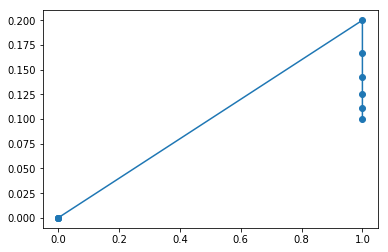

In [23]:
plt.plot(recall, precision, 'o-')
plt.show()

Actual row [1 1 0 0 1 0 0 0 0 0]
Actual precision [1.         1.         0.66666667 0.5        0.6       ]
Actual recall [0.33333333 0.66666667 0.66666667 0.66666667 1.        ]
Max precision [1.         1.         0.66666667 0.6        0.6       ]


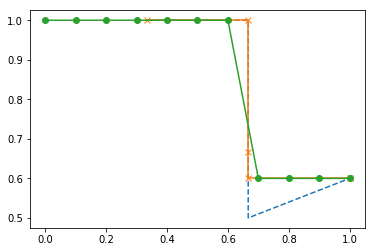

[0.77333333]
[0.85454545]


In [24]:
total = 0
precision = []
recall = []

row = 8
clm = 5
print("Actual row %s" % (rank_bin1[row, :]))

for i in range (len(rank_bin1[row,:clm])):
    total += rank_bin1[row,i]
    precision.append(total/(i+1))
    recall.append(total/np.sum(rank_bin1[row,:clm]))

precision = np.asarray(precision)
recall = np.asarray(recall)

recall1 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
recall1 = np.asarray(recall1)

i = recall1.shape[0]-2
j = recall.shape[0]-2

print("Actual precision %s" % (precision))
print("Actual recall %s" % (recall))

plt.plot(recall,precision, '--')



##interpolation of precisions by 11 step recalls
#print("Interp precision %s" %(precision_int))


#while i>0:       
#    if precision_int[i+1]>precision_int[i]:
#        precision_int[i] = precision_int[i+1]
#    i=i-1
while j>=0:       
    if precision[j+1]>precision[j]:
        precision[j] = precision[j+1]
    j=j-1
    
precision_int=np.interp(recall1, recall, precision)

print("Max precision %s" %(precision))

plt.plot(recall,precision, '-x')
plt.plot(recall1, precision_int, 'o-')
plt.show()
AP = np.sum(precision)/(precision.shape)
AP_int = np.sum(precision_int)/(precision_int.shape)
print(AP)
print(AP_int)

Actual row [1, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Actual precision [1.         1.         0.66666667 0.5        0.4        0.5
 0.57142857 0.5        0.44444444 0.5       ]
Actual recall [0.2 0.4 0.4 0.4 0.4 0.6 0.8 0.8 0.8 1. ]
[1.         1.         0.66666667 0.5        0.4        0.5
 0.57142857 0.5        0.44444444 0.5       ]
[1.         1.         0.66666667 0.5        0.4        0.5
 0.57142857 0.5        0.44444444 0.5       ]
[1.         1.         0.66666667 0.57142857 0.57142857 0.57142857
 0.57142857 0.5        0.5        0.5       ]
Interp precision [1.         1.         1.         1.         0.57142857 0.57142857
 0.57142857 0.57142857 0.5        0.5        0.5       ]
Max precision [1.         1.         0.66666667 0.57142857 0.57142857 0.57142857
 0.57142857 0.5        0.5        0.5       ]
[1.         1.         0.66666667 0.57142857 0.57142857 0.57142857
 0.57142857 0.5        0.5        0.5       ]
[1.         1.         0.66666667 0.57142857 0.57142857 0.57142857
 0.571

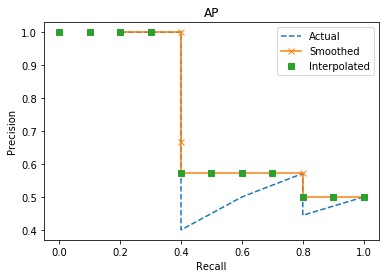

In [174]:
import matplotlib.pyplot

total = 0
precision = []
recall = []
precision1 = []

X = [1,1,0,0,0,1,1,0,0,1]
clm = 10
print("Actual row %s" % (X))

for i in range (10):
    total += X[i]
    precision.append(total/(i+1))
    recall.append(total/np.sum(X))

precision = np.asarray(precision)
recall = np.asarray(recall)

recall1 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
recall1 = np.asarray(recall1)

i = recall1.shape[0]-2
j = recall.shape[0]-2

print("Actual precision %s" % (precision))
print("Actual recall %s" % (recall))


temp = precision
precision1 = temp
plt.figure()
plt.plot(recall,precision1, '--')


print(precision)
print(precision1)
##interpolation of precisions by 11 step recalls




while j>=0:       
    if precision[j+1] > precision[j]:
        precision[j] = precision[j+1]
    j=j-1
    


print(precision)    
precision_int=np.interp(recall1, recall, precision)
print("Interp precision %s" %(precision_int))
print("Max precision %s" %(precision))
print(precision1)
print(precision)


plt.title('AP')

plt.plot(recall,precision, '-x')
plt.plot(recall1, precision_int, 's')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(['Actual', 'Smoothed', 'Interpolated'])

AP = np.sum(precision)/(precision.shape)
AP_int = np.sum(precision_int)/(precision_int.shape)
print(AP)
print(AP_int)
plt.savefig('AP.pdf', format='pdf', dpi=300)
plt.show()

## Finding mAP

In [88]:
#mAP for rank1

clm = 10
mAP =[]   
mAP_int=[]  ## mAP array of interpolated precision values

for row in range(1400):
    total = 0
    recall = []
    precision = []
    for i in range (len(rank_bin1[row,:clm])):
        total += rank_bin1[row,i]
        precision.append(total/(i+1))   #calculate precision
        recall.append(total/np.sum(rank_bin1[row,:clm]))    #calculate recall

    precision = np.asarray(precision)
    recall = np.asarray(recall)
    
    recall1 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]     #11 recall values
    recall1 = np.asarray(recall1)

    i = recall1.shape[0]-2
    j = recall.shape[0]-2
    
    
    ##maximizing precision (smoothening)
    while j>=0:       
        if precision[j+1]>precision[j]:  
            precision[j] = precision[j+1]
        j=j-1
    
    ##interpolation of precision to 11 values 
    precision_int=np.interp(recall1, recall, precision)
    
    AP = np.sum(precision)/(precision.shape)   ##average precision 
    AP_int = np.sum(precision_int)/(precision_int.shape)   ##average interpolated precision 
    
    mAP.append(AP)
    mAP_int.append(AP_int)
        
mAP = np.asarray(mAP)
mAP_int = np.asarray(mAP_int)
mAP_int = np.nan_to_num(mAP_int)


mAP_total = np.sum(mAP, axis = 0)/1400
mAP_int_total = np.sum(mAP_int, axis = 0)/1400

print("mAP: %s" %(mAP_total))
print("mAP: %s" %(mAP_int_total))

/Users/adilzhannussipzhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


mAP: [0.37050748]
mAP: [0.49290852]


## Improvement 

## PCA

In [28]:
print(train_f.shape)

(7368, 2048)


In [132]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

N = 200
pca = PCA(n_components = N)
pca.fit(train_f)
kpca = KernelPCA(n_components = N, kernel = 'cosine')
kpca.fit(train_f)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='cosine',
     kernel_params=None, max_iter=None, n_components=200, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)

In [ ]:
train_f = np.vstack((train_f.T, train_label, train_camid)) #transpose feature matrix to match dimensions 

train_f = train_f.T

In [44]:
k = 10 #number of nearest neighbors parameter

rank = []
distance = []
idx = []

import time
start_time = time.time()

##sqeuclidean instead of euclidean for computing efficientcy. As we are only interested in the ranklists
##and not the actual values of the distances.

for i in range (len(query[:,0])):
    
    ##getting rid of label/camid repetions 
    gallery_no_rep = gallery[~np.logical_and((gallery[:,-1] == query[i, -1]), (gallery[:,-2] == query[i, -2]))]
    
    query_f_test = query_f[i,:].reshape(1,-1)
    query_f_pca = pca.transform(query_f_test)

    gallery_f_pca = pca.transform(gallery_no_rep[:,:-2])
    
    NN = NearestNeighbors(n_neighbors = k, metric = 'sqeuclidean') #setting up NN
    NN.fit(gallery_f_pca, gallery_no_rep[:,-2])

   
    #query_f_test = query_f[i,:].reshape(1,-1)
    dist, idxs = NN.kneighbors(query_f_pca)
    
    distance.append(dist)
    idx.append(idxs)

distance = np.asarray(distance)
idx = np.asarray(idx)

print(idx.shape)

##creating ranklist of predicted labels (1400x10)
for i in range (len(query[:,0])):
    row_rank = []
    for j in range (len(idx[0,:])):
        row_rank.append(gallery[idx[i,j],-2])
    rank.append(row_rank)
    
rank = np.asarray(rank)     

    
print("--- %s seconds ---" % (time.time() - start_time))

print(rank.shape)

(1400, 1, 10)
--- 343.27097821235657 seconds ---
(1400, 1, 10)


In [46]:
rank = np.squeeze(rank)
print(rank.shape)
print(rank)

(1400, 10)
[[1367.  739. 1426. ... 1449.   51. 1367.]
 [ 509.  232.  232. ... 1426.    3.  171.]
 [   6.    6.    6. ...  678.  675.  647.]
 ...
 [1418. 1418. 1461. ... 1461. 1418. 1293.]
 [1463. 1463. 1463. ... 1435.  884.  905.]
 [1463. 1463.  884. ...  346.  346.  879.]]


In [47]:
query_label = query_label.reshape(1400,1)

rank_bin1 = []

for i in range (len(rank[:,0])):
    rank_bin = []
    for j in range (len(rank[0,:])): 
        if (rank[i,j] == query_label[i]):   ##if match, set 1, otherwise set 0
            rank_bin.append(1)
        else:
            rank_bin.append(0)
    rank_bin1.append(rank_bin)
    
    
rank_bin1 = np.asarray(rank_bin1)   ##array of label matches and mismatches
print(rank_bin1)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 1 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]]


In [48]:
rank_1 = np.sum(rank_bin1[:,0])/1400
r5 = rank_bin1[:,:5].sum(axis = 1)/5
rank_5 = np.count_nonzero(r5)/1400
r10 = rank_bin1[:,:10].sum(axis = 1)/5
rank_10 = np.count_nonzero(r10)/1400

print("Accuracy")
print("rank 1: %s" % (rank_1))
print("rank 5: %s" % (rank_5))
print("rank 10: %s" % (rank_10))

Accuracy
rank 1: 0.47
rank 5: 0.6785714285714286
rank 10: 0.7592857142857142


## KPCA

In [133]:
train_f = np.vstack((train_f.T, train_label, train_camid)) #transpose feature matrix to match dimensions 

train_f = train_f.T

In [134]:
#kernelPCA with cosine 


k = 10 #number of nearest neighbors parameter

rank = []
distance = []
idx = []

import time
start_time = time.time()

##sqeuclidean instead of euclidean for computing efficientcy. As we are only interested in the ranklists
##and not the actual values of the distances.

for i in range (len(query[:,0])):
    
    ##getting rid of label/camid repetions 
    gallery_no_rep = gallery[~np.logical_and((gallery[:,-1] == query[i, -1]), (gallery[:,-2] == query[i, -2]))]
    
    query_f_test = query_f[i,:].reshape(1,-1)
    query_f_kpca = kpca.transform(query_f_test)

    gallery_f_kpca = kpca.transform(gallery_no_rep[:,:-2])
    
    NN = NearestNeighbors(n_neighbors = k, metric = 'sqeuclidean') #setting up NN
    NN.fit(gallery_f_kpca, gallery_no_rep[:,-2])

   
    #query_f_test = query_f[i,:].reshape(1,-1)
    distkpca, idxskpca = NN.kneighbors(query_f_kpca)
    
    distance.append(distkpca)
    idx.append(idxskpca)

distance = np.asarray(distance)
idx = np.asarray(idx)

print(idx.shape)

##creating ranklist of predicted labels (1400x10)
for i in range (len(query[:,0])):
    row_rank = []
    for j in range (len(idx[0,:])):
        row_rank.append(gallery[idx[i,j],-2])
    rank.append(row_rank)
    
rank = np.asarray(rank)     

    
print("--- %s seconds ---" % (time.time() - start_time))

print(rank.shape)

(1400, 1, 10)
--- 10420.601171970367 seconds ---
(1400, 1, 10)


In [135]:
rank = np.squeeze(rank)
print(rank.shape)
print(rank)

(1400, 10)
[[1367.   51.  739. ... 1449.  115.  660.]
 [ 509.  232.  232. ...  509.  742.  171.]
 [   6.    6.    6. ...   76.  647.  675.]
 ...
 [1418. 1418. 1461. ... 1461. 1418. 1293.]
 [1463. 1463. 1463. ...  905. 1204.  884.]
 [1463. 1463.  884. ...  884.  879.  346.]]


In [136]:
query_label = query_label.reshape(1400,1)

rank_bin1 = []

for i in range (len(rank[:,0])):
    rank_bin = []
    for j in range (len(rank[0,:])): 
        if (rank[i,j] == query_label[i]):   ##if match, set 1, otherwise set 0
            rank_bin.append(1)
        else:
            rank_bin.append(0)
    rank_bin1.append(rank_bin)
    
    
rank_bin1 = np.asarray(rank_bin1)   ##array of label matches and mismatches
print(rank_bin1)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 1 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]]


In [137]:
rank_1 = np.sum(rank_bin1[:,0])/1400
r5 = rank_bin1[:,:5].sum(axis = 1)/5
rank_5 = np.count_nonzero(r5)/1400
r10 = rank_bin1[:,:10].sum(axis = 1)/5
rank_10 = np.count_nonzero(r10)/1400

print("Accuracy")
print("rank 1: %s" % (rank_1))
print("rank 5: %s" % (rank_5))
print("rank 10: %s" % (rank_10))

Accuracy
rank 1: 0.4764285714285714
rank 5: 0.6785714285714286
rank 10: 0.7564285714285715


### LMNN

In [ ]:
## large margin nearest neighbour 

In [63]:
# plotting stuff (TODO)


# this is our data
X = query_f
# these are our constraints
Y = gallery_f

# function to plot the results
def plot(X, Y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    plt.figure(2, figsize=(8, 6))

    # clean the figure
    plt.clf()

    plt.scatter(X[:, 0], X[:, 1],cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

    plt.show()
    


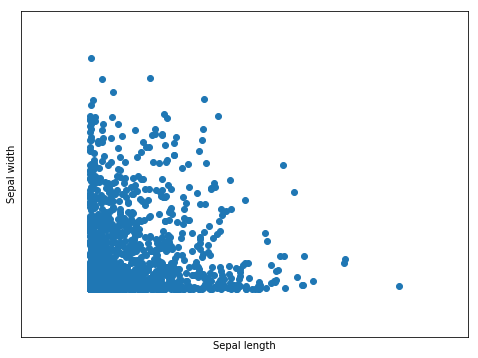

In [64]:
plot(X,Y)

In [128]:
from metric_learn import LMNN
from mpl_toolkits.mplot3d import Axes3D

k = 5 

rank = []
distance = []
idx = []

import time
start_time = time.time()

lmnn = LMNN(k,learn_rate = 1e-6)
lmnn.fit(train_f, train_label)

for i in range (len(query[:,0])):
    
    ##getting rid of label/camid repetions 
    gallery_no_rep = gallery[~np.logical_and((gallery[:,-1] == query[i, -1]), (gallery[:,-2] == query[i, -2]))]
    
    query_f_test = query_f[i,:].reshape(1,-1)
    query_f_lmnn = lmnn.transform(query_f_test)

    gallery_f_lmnn = lmnn.transform(gallery_no_rep[:,:-2])

    
    NN = NearestNeighbors(n_neighbors = k, metric = 'sqeuclidean') #setting up NN
    NN.fit(gallery_f_lmnn, gallery_no_rep[:,-2])
    
    dist, idxs = NN.kneighbors(query_f_lmnn)
    
    distance.append(dist)
    idx.append(idxs)

distance = np.asarray(distance)
idx = np.asarray(idx)

print(idx.shape)

##creating ranklist of predicted labels (1400x10)
for i in range (len(query[:,0])):
    row_rank = []
    for j in range (len(idx[0,:])):
        row_rank.append(gallery[idx[i,j],-2])
    rank.append(row_rank)
    
rank = np.asarray(rank)     

    
print("--- %s seconds ---" % (time.time() - start_time))

print(rank.shape)

/Users/adilzhannussipzhan/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


(1400, 1, 5)
--- 2463.008589744568 seconds ---
(1400, 1, 5)


In [129]:
rank = np.squeeze(rank)
print(rank.shape)
print(rank)

(1400, 5)
[[1367. 1368.  739. 1367. 1367.]
 [ 509.  171.  232.  723.  232.]
 [   6.    6.    6.    6.   76.]
 ...
 [1418. 1418. 1461. 1418. 1418.]
 [1463. 1463. 1463.  905.  905.]
 [1463. 1463. 1463.  884.  884.]]


In [130]:
query_label = query_label.reshape(1400,1)

rank_bin1 = []

for i in range (len(rank[:,0])):
    rank_bin = []
    for j in range (len(rank[0,:])): 
        if (rank[i,j] == query_label[i]):   ##if match, set 1, otherwise set 0
            rank_bin.append(1)
        else:
            rank_bin.append(0)
    rank_bin1.append(rank_bin)
    
    
rank_bin1 = np.asarray(rank_bin1)   ##array of label matches and mismatches
print(rank_bin1)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 0]
 ...
 [0 0 1 0 0]
 [1 1 1 0 0]
 [1 1 1 0 0]]


In [131]:
rank_1 = np.sum(rank_bin1[:,0])/1400
r5 = rank_bin1[:,:5].sum(axis = 1)
rank_5 = np.count_nonzero(r5)/1400
r10 = rank_bin1[:,:10].sum(axis = 1)
rank_10 = np.count_nonzero(r10)/1400

print("Accuracy")
print("rank 1: %s" % (rank_1))
print("rank 5: %s" % (rank_5))
print("rank 10: %s" % (rank_10))

Accuracy
rank 1: 0.45357142857142857
rank 5: 0.665
rank 10: 0.665


In [124]:
from metric_learn import LFDA

k = 3 

rank = []
distance = []
idx = []

import time
start_time = time.time()

lfda = LFDA(k)
lfda.fit(train_f, train_label)

for i in range (len(query[:,0])):
    
    ##getting rid of label/camid repetions 
    gallery_no_rep = gallery[~np.logical_and((gallery[:,-1] == query[i, -1]), (gallery[:,-2] == query[i, -2]))]
    
    query_f_test = query_f[i,:].reshape(1,-1)
    query_f_lfda = lfda.transform(query_f_test)

    gallery_f_lfda = lfda.transform(gallery_no_rep[:,:-2])

    
    NN = NearestNeighbors(n_neighbors = k, metric = 'sqeuclidean') #setting up NN
    NN.fit(gallery_f_lfda, gallery_no_rep[:,-2])
    
    dist, idxs = NN.kneighbors(query_f_lfda)
    
    distance.append(dist)
    idx.append(idxs)

distance = np.asarray(distance)
idx = np.asarray(idx)

print(idx.shape)

##creating ranklist of predicted labels (1400x10)
for i in range (len(query[:,0])):
    row_rank = []
    for j in range (len(idx[0,:])):
        row_rank.append(gallery[idx[i,j],-2])
    rank.append(row_rank)
    
rank = np.asarray(rank)     

    
print("--- %s seconds ---" % (time.time() - start_time))

print(rank.shape)

(1400, 1, 3)
--- 283.0705831050873 seconds ---
(1400, 1, 3)


In [125]:
rank = np.squeeze(rank)
print(rank.shape)
print(rank)

(1400, 3)
[[ 469. 1326.  726.]
 [1385.  112.  401.]
 [   6.  241.  831.]
 ...
 [ 180.  180.  557.]
 [ 255.  885.  832.]
 [1349. 1349. 1432.]]


In [126]:
query_label = query_label.reshape(1400,1)

rank_bin1 = []

for i in range (len(rank[:,0])):
    rank_bin = []
    for j in range (len(rank[0,:])): 
        if (rank[i,j] == query_label[i]):   ##if match, set 1, otherwise set 0
            rank_bin.append(1)
        else:
            rank_bin.append(0)
    rank_bin1.append(rank_bin)
    
    
rank_bin1 = np.asarray(rank_bin1)   ##array of label matches and mismatches
print(rank_bin1)

[[0 0 0]
 [0 0 0]
 [1 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [127]:
rank_1 = np.sum(rank_bin1[:,0])/1400
r5 = rank_bin1[:,:5].sum(axis = 1)
rank_5 = np.count_nonzero(r5)/1400
r10 = rank_bin1[:,:10].sum(axis = 1)
rank_10 = np.count_nonzero(r10)/1400

print("Accuracy")
print("rank 1: %s" % (rank_1))
print("rank 5: %s" % (rank_5))
print("rank 10: %s" % (rank_10))

Accuracy
rank 1: 0.029285714285714286
rank 5: 0.07285714285714286
rank 10: 0.07285714285714286
